# Predicting whether the person survived or not using machine learning

## 1. Problem Definition
Given information about the passenger of titanic, can we predict whether or not they survived after crash?

## 2. Features

* **Survived**: Outcome of survival (0 = No; 1 = Yes)
* **Pclass**: Ticket class
* **Name**: Name of passenger
* **Sex**: Sex of the passenger
* **Age**: Age of the passenger
* **SibSp**: Number of siblings / spouses aboard the titanic
* **Parch**: Number of parents/ children aboard the titanic
* **Ticket**: Ticket number of the passenger
* **Fare**: Passenger fare
* **Cabin** Cabin number of the passenger
* **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

**Variable explanations**
* **pclass**: A proxy for socio-economic status (SES)
    * 1st = Upper
    * 2nd = Middle
    * 3rd = Lower

* **age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* **sibsp**: The dataset defines family relations in this way...
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)

* **parch**: The dataset defines family relations in this way...
    * Parent = mother, father
    * Child = daughter, son, stepdaughter, stepson
        * Some children travelled only with a nanny, therefore parch=0 for them

## 3. Hypothesis
* Women were more likely to have survived in crash. 
* The passengers with high socio-economic status were more likely to have survived in crash. 
* There can be high correlation between pclass and fare as high-class passengers probably paid more for the ticket. 
* Senior people were probably to have survived in crash 
* Men who traveled alone were most likely to have died in crash 
* Men with low socio-economic status were most likely to have died in crash 
* Women with high socio-economic status were most likely to have survived in crash 

## Preparing the tools

In [359]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score,roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve, roc_curve, plot_confusion_matrix
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman',
              "style":'whitegrid'})
sns.set(font_scale = 1.5)

## Load the data

In [360]:
df = pd.read_csv("data/Classification_Titanic.csv")

## Data Exploration

In [361]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [362]:
# Checking target imbalance
df["Survived"].value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


In [364]:
# Are there any missing values?
df.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64

In [365]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,49999.500000,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,28867.657797,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,24999.750000,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,49999.500000,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,74999.250000,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,99999.000000,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


In [366]:
# Compare target with sex
pd.crosstab(df.Survived,df.Sex)

Sex,female,male
Survived,,
0,12660,44566
1,31226,11548


In [367]:
def show_cross_graph(df,feature, xlabel, rot=90):
    pd.crosstab(df[feature],df.Survived).plot(kind="bar",
                                    figsize=(10,6),
                                    color=["salmon","lightblue","grey"])
    plt.title(f"Survival rate for {feature}")
    plt.xlabel(xlabel)
    plt.xticks(rotation=rot)
    plt.ylabel("Count")
    plt.legend(["Died","Survived"]);

## Sex vs Survived
As you see from the graph, there is high chance for female to survive than male

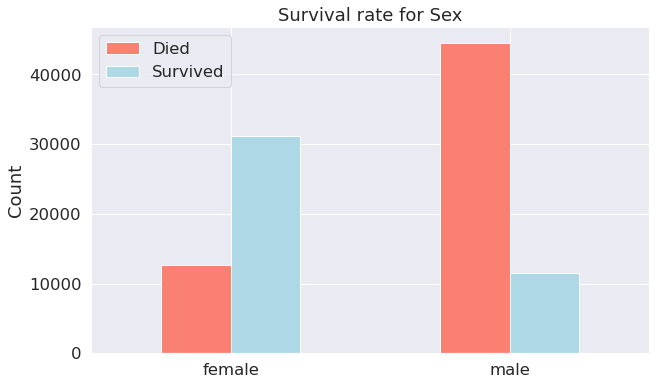

In [368]:
show_cross_graph(df,"Sex", "",0)

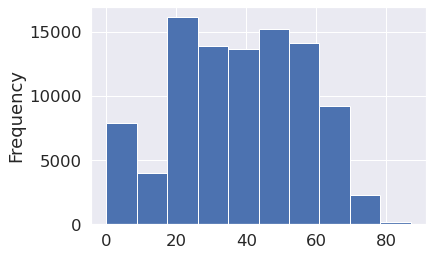

In [369]:
# Age distribution
df.Age.plot.hist();

## Age vs Survival ratio
As you noticed, for the ages more than around 70, there is high chance to survive

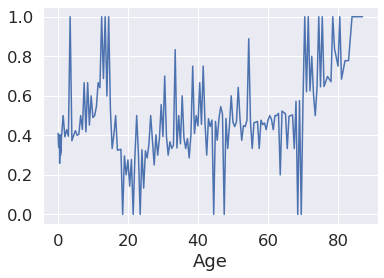

In [370]:
corr1 = pd.crosstab(df.Age,df.Survived)
corr2 = pd.crosstab(df.Age,df.Age)
ratio = corr1[1]/(corr1[0]+corr1[1])
sns.lineplot(x = corr2.columns, y = ratio);

## Pclass vs Survived
As you can see from the graph, upper class people are more likely to survive compared to others.

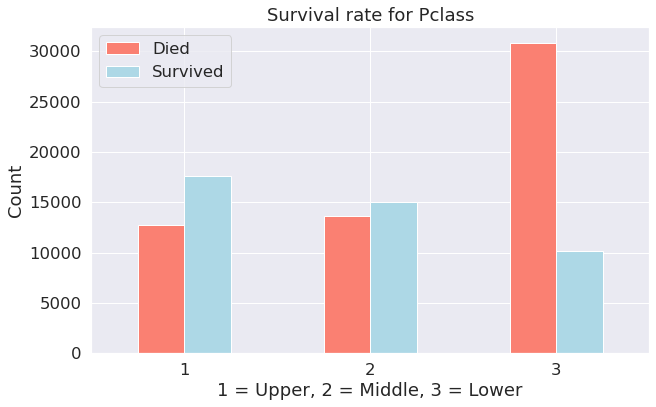

In [371]:
show_cross_graph(df,"Pclass","1 = Upper, 2 = Middle, 3 = Lower",0)

## Parch vs Survived

There is sufficient information about alone people (parch = 0). It is more likely that they did not survive.

<AxesSubplot:ylabel='Frequency'>

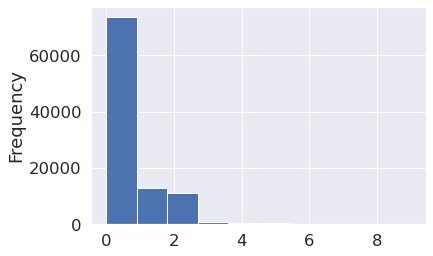

In [372]:
# Parch distribution
df.Parch.plot.hist()

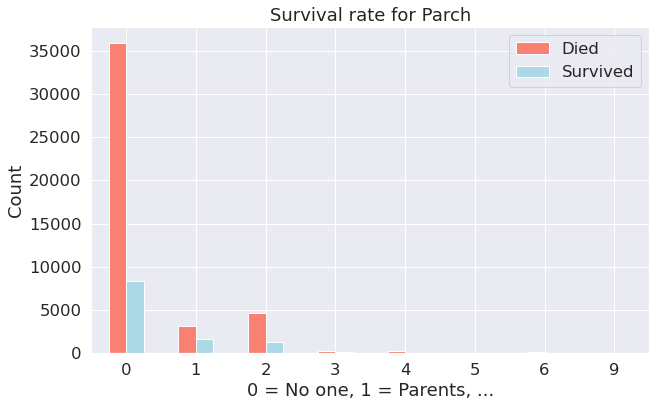

In [373]:
show_cross_graph(df[df["Sex"]=="male"],"Parch","0 = No one, 1 = Parents, ...",0)

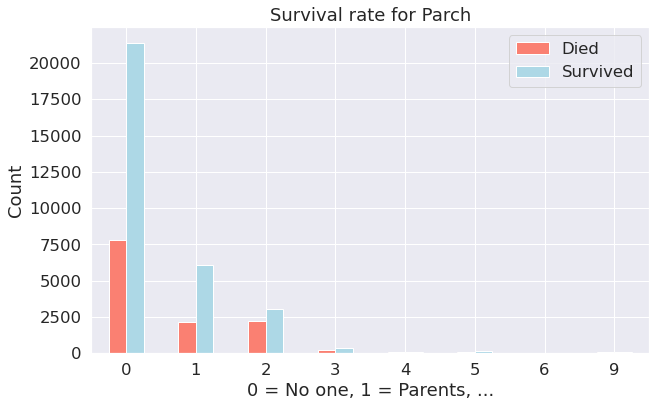

In [374]:
show_cross_graph(df[df["Sex"]=="female"],"Parch","0 = No one, 1 = Parents, ...",0)

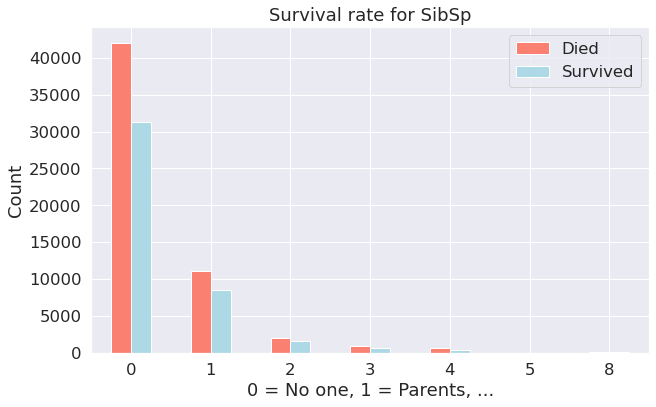

In [375]:
show_cross_graph(df,"SibSp","0 = No one, 1 = Parents, ...",0)

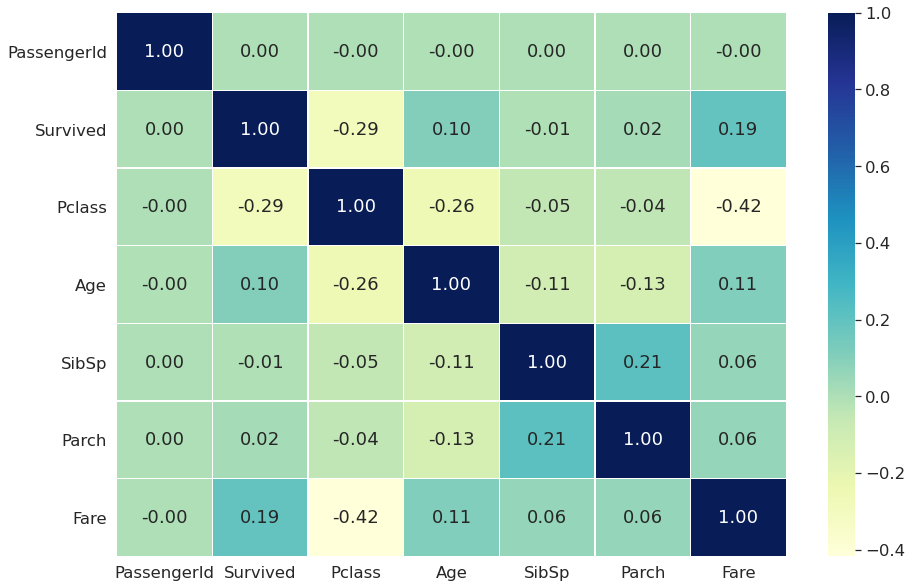

In [376]:
# Correlation matrix for features
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.heatmap(df.corr(),
                annot=True,
                linewidths=0.5,
                fmt = ".2f",
                cmap = "YlGnBu");

As can be seen from the table, as you move down in **Pclass**, the **Fare** increases 

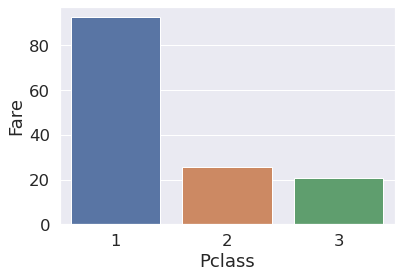

In [377]:
# Checking correlation
temp = df[['Pclass', 'Fare']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Pclass', ascending=True)

sns.barplot(x = temp[temp.columns[0]],y = temp[temp.columns[1]]);

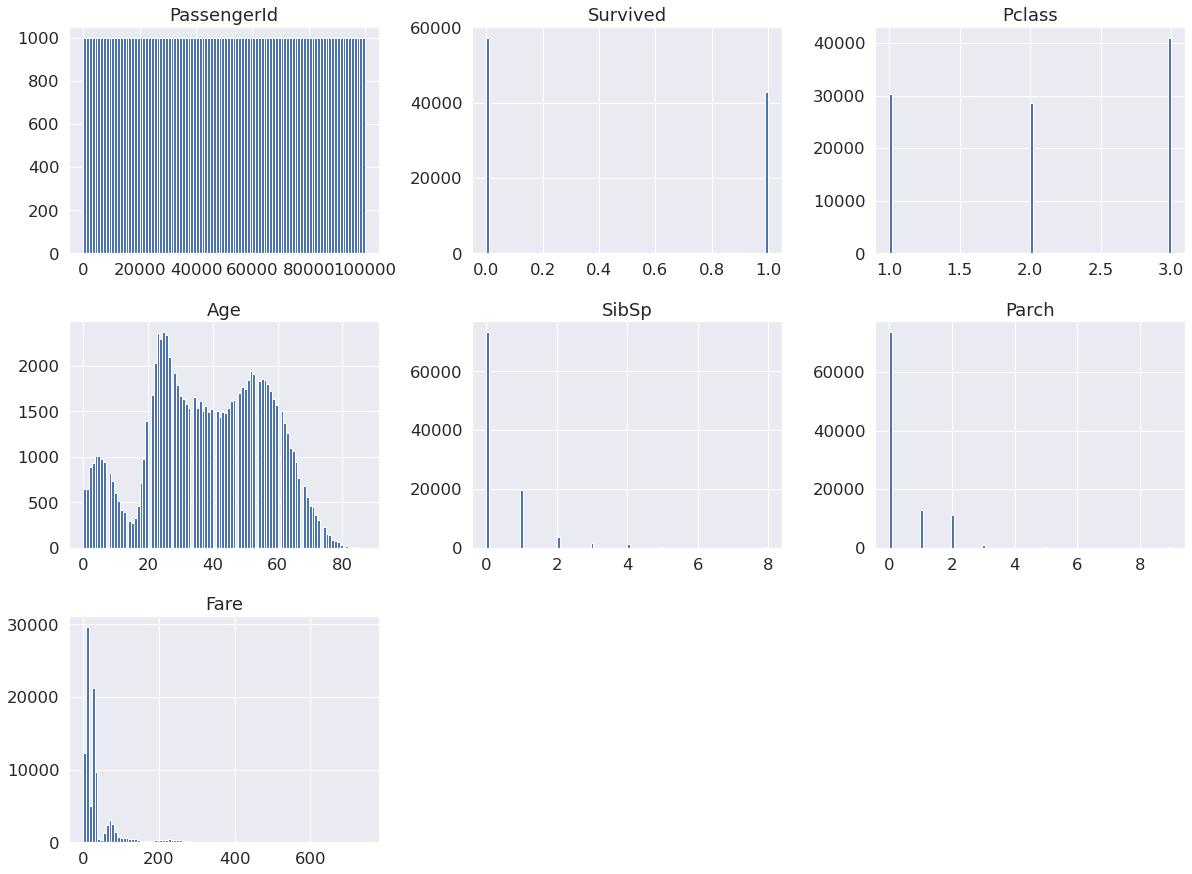

In [378]:
df.hist(bins=100, figsize=(20, 15))
plt.show()

## Data Processing and Feature Engineering
We will do following processes:
* We will make a new column called **FamilySize** that will be sum of **Parch** and **SibSp**. 
* **FamilySize** column is imbalanced so to make it simple, It will consist of binary values. (0 => people traveled alone, 1 => people traveled with family)
* **Fare** has continuous values. It is better to make it discrete. 
* There is unnecessary information about passengers. We will remove **Passenger ID, Ticket, Name, Cabin** from data
* **Age**, **Fare**, **Embarked** columns have NaN values. NaN values of **Age**, **Fare** will be filled with median of each respectively and NaN values of Embarked will be filled with the most frequent value
* We will make 3 columns (**Poor, Middle, Rich**) based on the values of **Pclass**
* We will make a new column called **Rich Female** who are the females with **Pclass** of 1 or 2
* We will make a new column called **Poor Male** who are the males with **Pclass** of 3
* We will make two columns (**High Fare**, **Low Fare**) based on the values of **Fare**
* We will make a new column called **Female C** who are the females that embarked from **Cherbourg**
* We will make a new column called **Male S** who are the males that embarked from **Southampton**
* We will make a new column called **Adult Male** who are the males with age between 20 and 40
* We will make a new column called **Senior People** who are over 75 years old
* Finally we will remove  **Age**, **Fare**, **Pclass**, **FamilySize**, **Embarked**, **Parch** and **SibSp** columns

In [379]:
def show_table(df,feature):
    return df[[feature, 'Survived']].groupby([feature], as_index=False).mean().sort_values(by=feature, ascending=True)

In [380]:
df["FamilySize"] = df["SibSp"]+df["Parch"] + 1
df.drop(["SibSp","Parch"], axis = 1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize
0,0,1,1,"Oconnor, Frankie",male,NaN,209245,27.14,C12239,S,3
1,1,0,3,"Bryan, Drew",male,NaN,27323,13.35,NaN,S,1
2,2,0,3,"Owens, Kenneth",male,0.33,CA 457703,71.29,NaN,S,4
3,3,0,3,"Kramer, James",male,19.00,A. 10866,13.04,NaN,S,1
4,4,1,3,"Bond, Michael",male,25.00,427635,7.76,NaN,S,1


In [381]:
# Family size distribution
df.FamilySize.value_counts()

1     61853
2     14212
3     10789
4      8810
5      1870
6      1274
7       498
10      314
11      128
9       111
8       104
12       20
13        7
14        5
15        3
18        2
Name: FamilySize, dtype: int64

In [382]:
# Family size column is imbalanced so to make it simple, It will consist of binary values. (0 => people traveled alone, 1 => with family)

df.loc[df.FamilySize<=1,"FamilySize"] = 0
df.loc[df.FamilySize>1, "FamilySize"] = 1
df.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize
0,0,1,1,"Oconnor, Frankie",male,NaN,209245,27.14,C12239,S,1
1,1,0,3,"Bryan, Drew",male,NaN,27323,13.35,NaN,S,0
2,2,0,3,"Owens, Kenneth",male,0.33,CA 457703,71.29,NaN,S,1
3,3,0,3,"Kramer, James",male,19.00,A. 10866,13.04,NaN,S,0
4,4,1,3,"Bond, Michael",male,25.00,427635,7.76,NaN,S,0
5,5,0,2,"Sassano, Jonathan",male,35.00,13363,6.71,NaN,S,0
6,6,0,3,"Conway, Jose",male,7.00,A/5,9.77,NaN,S,0
7,7,1,3,"Werner, Linda",female,6.00,434426,31.50,NaN,S,1
8,8,0,1,"Wardlaw, Michael",male,27.00,474849,73.02,A7253,S,1
9,9,0,2,"Greigo, Rudy",male,66.00,6981,9.14,D2969,C,0


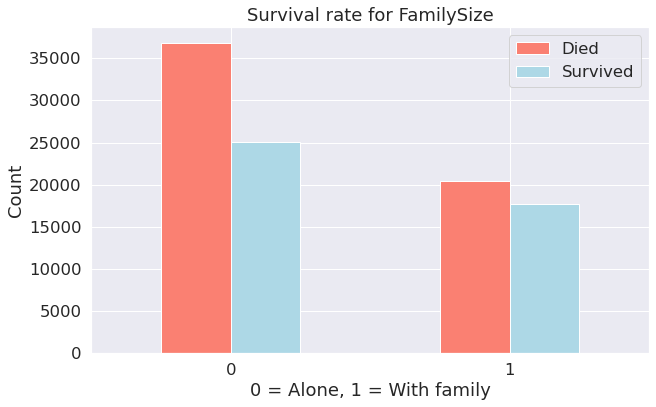

In [383]:
show_cross_graph(df,"FamilySize", "0 = Alone, 1 = With family", 0)

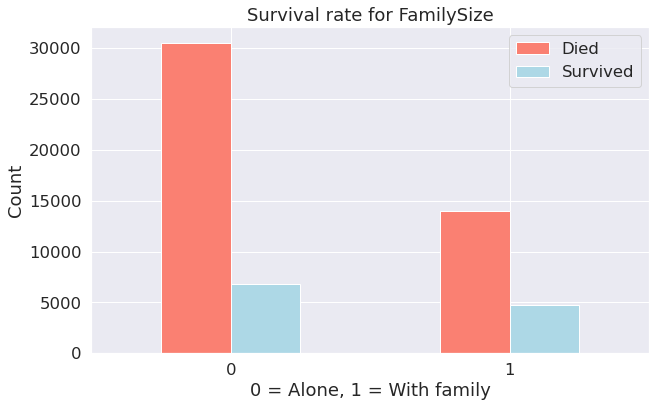

In [384]:
show_cross_graph(df[df["Sex"]=="male"],"FamilySize", "0 = Alone, 1 = With family", 0)

In [385]:
# Find out the most frequent
most_freq = df.Embarked.dropna().mode()[0]

In [386]:
# Filling up NaN values
df.Age.replace([None],[df.Age.median()],inplace=True)
df.Embarked.replace([None],[most_freq], inplace=True)
df.Fare.replace([None],[df.Fare.median()],inplace=True)

In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          100000 non-null  float64
 6   Ticket       95377 non-null   object 
 7   Fare         100000 non-null  float64
 8   Cabin        32134 non-null   object 
 9   Embarked     100000 non-null  object 
 10  FamilySize   100000 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 8.4+ MB


In [388]:
# Drop unnecessary columns
df.drop(["Ticket","PassengerId","Cabin","Name"],axis=1,inplace=True)

In [389]:
df["High Fare"] = 0
df["Low Fare"] = 0
df.loc[(df["Fare"]>80) & (df["Fare"]<=1000), "High Fare"] = 1
df.loc[(df["Fare"]>0) & (df["Fare"]<=10), "Low Fare"] = 1
df.drop("Fare",inplace=True,axis=1);

In [390]:
show_table(df,"High Fare")

,High Fare,Survived
0,0,0.393686
1,1,0.662380


In [391]:
show_table(df,"Low Fare")

,Low Fare,Survived
0,0,0.487535
1,1,0.245960


In [392]:
df["Senior People"] = 0
df.loc[(df["Age"]>75) & (df["Age"]<=1000), "Senior People"] = 1
df["Adult Male"] = 0
df.loc[(df["Age"]>20) & (df["Sex"] == "male") & (df["Age"]<=40), "Adult Male"] = 1
df.drop("Age",inplace=True,axis=1)

In [393]:
show_table(df, "Senior People")

,Senior People,Survived
0,0,0.426471
1,1,0.714286


In [394]:
show_table(df,"Adult Male")

,Adult Male,Survived
0,0,0.512608
1,1,0.179085


In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Survived       100000 non-null  int64 
 1   Pclass         100000 non-null  int64 
 2   Sex            100000 non-null  object
 3   Embarked       100000 non-null  object
 4   FamilySize     100000 non-null  int64 
 5   High Fare      100000 non-null  int64 
 6   Low Fare       100000 non-null  int64 
 7   Senior People  100000 non-null  int64 
 8   Adult Male     100000 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 6.9+ MB


In [396]:
# Make Pclass as categorical
df["Poor"] =  [1 if i == 3 else 0 for i in df['Pclass']]
df["Middle"] = [1 if i == 2 else 0 for i in df['Pclass']]
df["Rich"] = [1 if i == 1 else 0 for i in df['Pclass']]
df["Rich Female"] = 0
df["Poor Male"] = 0
df.loc[(df['Pclass']<=2) & (df['Sex']=="female"), 'Rich Female'] = 1
df.loc[(df['Pclass']>=2) & (df['Sex']=="male"), 'Poor Male'] = 1
df.drop("Pclass",axis=1,inplace=True)

In [397]:
df["Male S"]  = 0
df["Female C"] = 0
df.loc[(df['Embarked']=='C') & (df['Sex']=="female"), "Female C"] = 1
df.loc[(df['Embarked']=='S') & (df['Sex']=="male"), "Male S"] = 1
df.drop("Embarked",axis=1,inplace=True)

In [398]:
show_table(df,"Male S")

,Male S,Survived
0,0,0.676411
1,1,0.159864


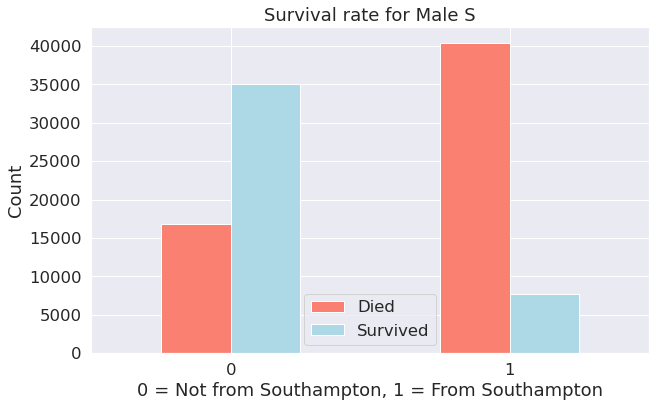

In [399]:
show_cross_graph(df,"Male S","0 = Not from Southampton, 1 = From Southampton", 0)

In [400]:
show_table(df,"Female C")

,Female C,Survived
0,0,0.349206
1,1,0.846700


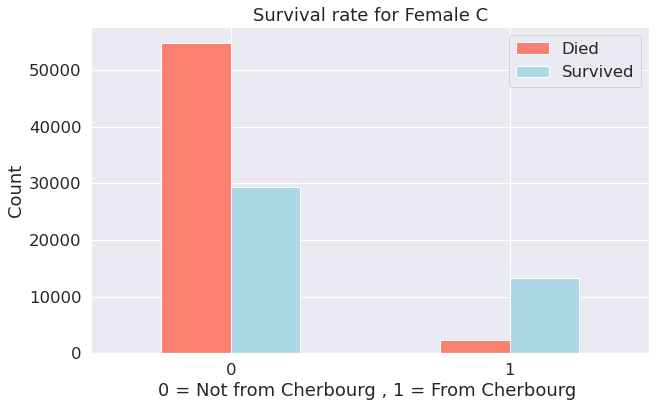

In [401]:
show_cross_graph(df,"Female C","0 = Not from Cherbourg , 1 = From Cherbourg ", 0)

In [402]:
show_table(df,"Rich Female")

,Rich Female,Survived
0,0,0.271939
1,1,0.768642


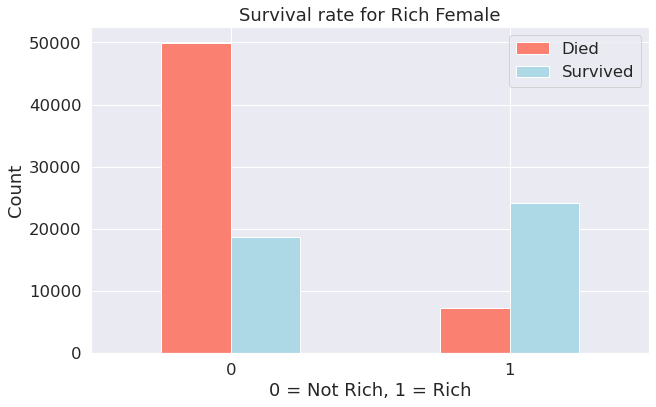

In [403]:
show_cross_graph(df,"Rich Female", "0 = Not Rich, 1 = Rich", 0)

In [404]:
show_table(df,"Poor Male")

,Poor Male,Survived
0,0,0.627097
1,1,0.151111


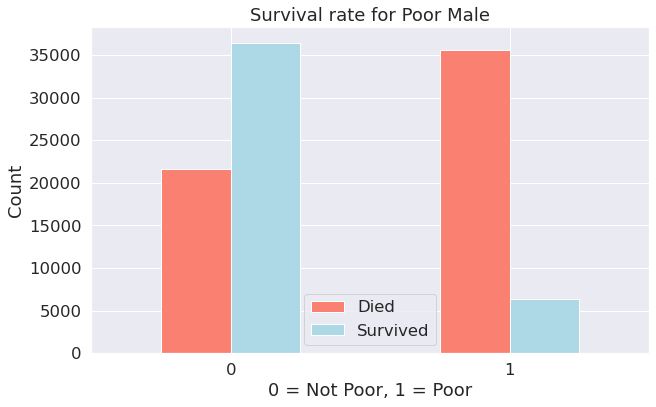

In [405]:
show_cross_graph(df,"Poor Male", "0 = Not Poor, 1 = Poor", 0)

In [406]:
df["Alone Male"] = 0
df.loc[(df["FamilySize"]==0) & (df["Sex"]=="male"), "Alone Male"] = 1
df.drop("FamilySize",inplace=True,axis=1)

In [407]:
show_table(df,"Alone Male")

,Alone Male,Survived
0,0,0.574261
1,1,0.182032


In [408]:
df.loc[df['Sex']=='male','Sex'] = 0
df.loc[df['Sex']=='female','Sex'] = 1
df['Sex']  = df['Sex'].astype(int)

In [409]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Survived       100000 non-null  int64
 1   Sex            100000 non-null  int64
 2   High Fare      100000 non-null  int64
 3   Low Fare       100000 non-null  int64
 4   Senior People  100000 non-null  int64
 5   Adult Male     100000 non-null  int64
 6   Poor           100000 non-null  int64
 7   Middle         100000 non-null  int64
 8   Rich           100000 non-null  int64
 9   Rich Female    100000 non-null  int64
 10  Poor Male      100000 non-null  int64
 11  Male S         100000 non-null  int64
 12  Female C       100000 non-null  int64
 13  Alone Male     100000 non-null  int64
dtypes: int64(14)
memory usage: 10.7 MB


In [410]:
df.head()

,Survived,Sex,High Fare,Low Fare,Senior People,Adult Male,Poor,Middle,Rich,Rich Female,Poor Male,Male S,Female C,Alone Male
0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
1,0,0,0,0,0,1,1,0,0,0,1,1,0,1
2,0,0,0,0,0,0,1,0,0,0,1,1,0,0
3,0,0,0,0,0,0,1,0,0,0,1,1,0,1
4,1,0,0,1,0,1,1,0,0,0,1,1,0,1


## Modelling

We are going to try 3 different machine learning algorithms for this dataset

* LogisticRegression
* K-Nearest Neighbours Classifier
* Random Forest Classifier

In [411]:
# Split the data into train and test set
np.random.seed(0)

X = df.drop("Survived",axis=1)
y = df.Survived

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.05,stratify=y)
print(y_train.value_counts(),y_test.value_counts())

0    54365
1    40635
Name: Survived, dtype: int64 0    2861
1    2139
Name: Survived, dtype: int64


Now we will use **RandomizedSearchCV** to find out best parameters for each classifier

In [412]:
models = {"LR": LogisticRegression(max_iter=10000), "KNN": KNeighborsClassifier(), "RF": RandomForestClassifier()}

In [413]:
def default_train_test(models,X_train,y_train,X_test,y_test):
    results = {"Evaluation": [], "Model":[]}
    temp = pd.DataFrame(columns=["Evaluation","Model"])
    cv = StratifiedKFold(n_splits=10,random_state=100,shuffle=True)
    for name,model in models.items():
        scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
        temp1 = pd.DataFrame({"Evaluation":scores,"Model": [name]*10})
        temp = temp.append(temp1,ignore_index=True)
    return temp

In [414]:
np.random.seed(42)
results = default_train_test(models,X_train,y_train,X_test,y_test)

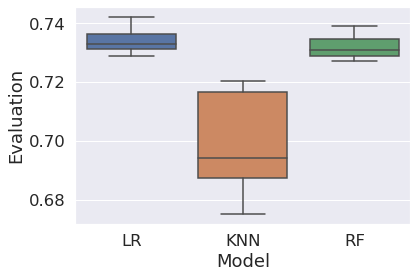

In [415]:
sns.boxplot(x="Model",y="Evaluation", data = results);

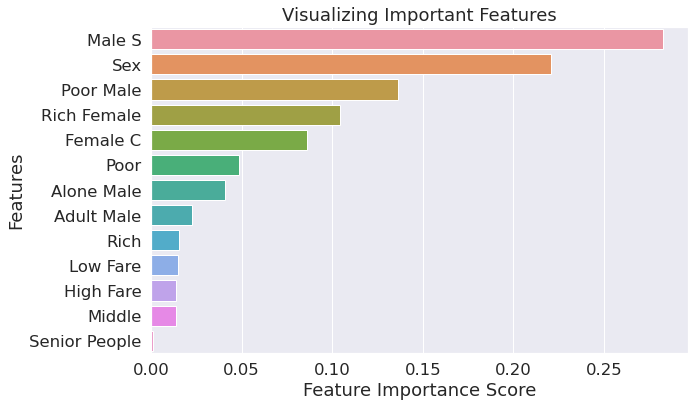

In [416]:
# Checking feature importance
np.random.seed(42)
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
feature_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

In [417]:
# Try out different parameters for each classifier
knn_params = {'n_neighbors': np.arange(2,52), 'weights': ['uniform','distance']}
lr_params = {"C": np.logspace(-6, 6,20),
                "solver": ["liblinear","lbfgs"]}
rf_params = {"n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
           "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
           "min_samples_split": [2, 5, 10],
           "min_samples_leaf": [1, 2, 4]}
params = {"LR":lr_params,"KNN":knn_params,"RF":rf_params}

In [418]:
def doExperiment(models,params,X_train,y_train,X_test,y_test):
    model_res = {}
    for name,model in models.items():
        model_res[name] = fit_and_score(model,params[name],X_train,y_train,X_test,y_test)
    return model_res

def fit_and_score(model,params,X_train,y_train,X_test,y_test):
    print(f"Training {model}")
    cv = StratifiedKFold(n_splits=10,shuffle=True)
    m = RandomizedSearchCV(model,
                                param_distributions=params,
                                cv=cv,
                                n_iter = 30,
                                scoring = "f1",
                                  n_jobs=-1)
    m.fit(X_train,y_train)
    return {"best_params":m.best_params_,"test_score": m.score(X_test,y_test), "train_score": m.score(X_train,y_train)}
    

## If you want to reproduce the results please uncomment this cell

In [419]:
# np.random.seed(42)
# result = doExperiment(models,params,X_train,y_train,X_test,y_test)
# result

Training LogisticRegression(max_iter=10000)
Training KNeighborsClassifier()
Training RandomForestClassifier()


{'LR': {'best_params': {'solver': 'lbfgs', 'C': 0.4832930238571752},
  'test_score': 0.7331828442437922,
  'train_score': 0.7359185364987271},
 'KNN': {'best_params': {'weights': 'uniform', 'n_neighbors': 43},
  'test_score': 0.7303473491773309,
  'train_score': 0.7320476093444727},
 'RF': {'best_params': {'n_estimators': 400,
   'min_samples_split': 10,
   'min_samples_leaf': 2,
   'max_depth': 60},
  'test_score': 0.7290322580645161,
  'train_score': 0.7330549386888097}}

Now we found the best parameters for each classifier. We will start comparing them. 

In [430]:
np.random.seed(42)
lr = LogisticRegression(C = 0.4832930238571752, solver = "lbfgs")
knn = KNeighborsClassifier(weights='uniform',n_neighbors=43)
rf = RandomForestClassifier(n_estimators=400,min_samples_split=10,min_samples_leaf=2,max_depth=60)
lr.fit(X_train,y_train)
knn.fit(X_train,y_train)
rf.fit(X_train,y_train)
models = {"Logistic Regression":lr,"K-Nearest Neighbors":knn,"Random Forest":rf}

Now we will compare three models by using several evaluation methods. Namely **Accuracy**, **Precision**, **Recall**, **F1-Score**, **ROC curve**

In [431]:
def get_scores(models, X_test,y_test):
    df = pd.DataFrame(columns=["Evaluation","Method","Model"])
    for name,model in models.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        temp = pd.DataFrame({"Evaluation":[
            accuracy_score(y_test,y_pred)*100,
            precision_score(y_test,y_pred)*100,
            recall_score(y_test,y_pred)*100,
            f1_score(y_test,y_pred)*100,
            roc_auc_score(y_test,y_proba)*100
             ],
            "Method":[
                "Accuracy",
                "Precision",
                "Recall",
                "F1-Score",
                "ROC"],
            "Model":[name]*5})
        df = df.append(temp,ignore_index=True)
    return df

In [432]:
final_results = get_scores(models,X_test,y_test)

In [433]:
final_results

,Evaluation,Method,Model
0,76.360000,Accuracy,Logistic Regression
1,70.886076,Precision,Logistic Regression
2,75.923329,Recall,Logistic Regression
3,73.318284,F1-Score,Logistic Regression
4,83.215999,ROC,Logistic Regression
5,76.400000,Accuracy,K-Nearest Neighbors
6,71.434958,Precision,K-Nearest Neighbors
7,74.707807,Recall,K-Nearest Neighbors
8,73.034735,F1-Score,K-Nearest Neighbors
9,82.641524,ROC,K-Nearest Neighbors


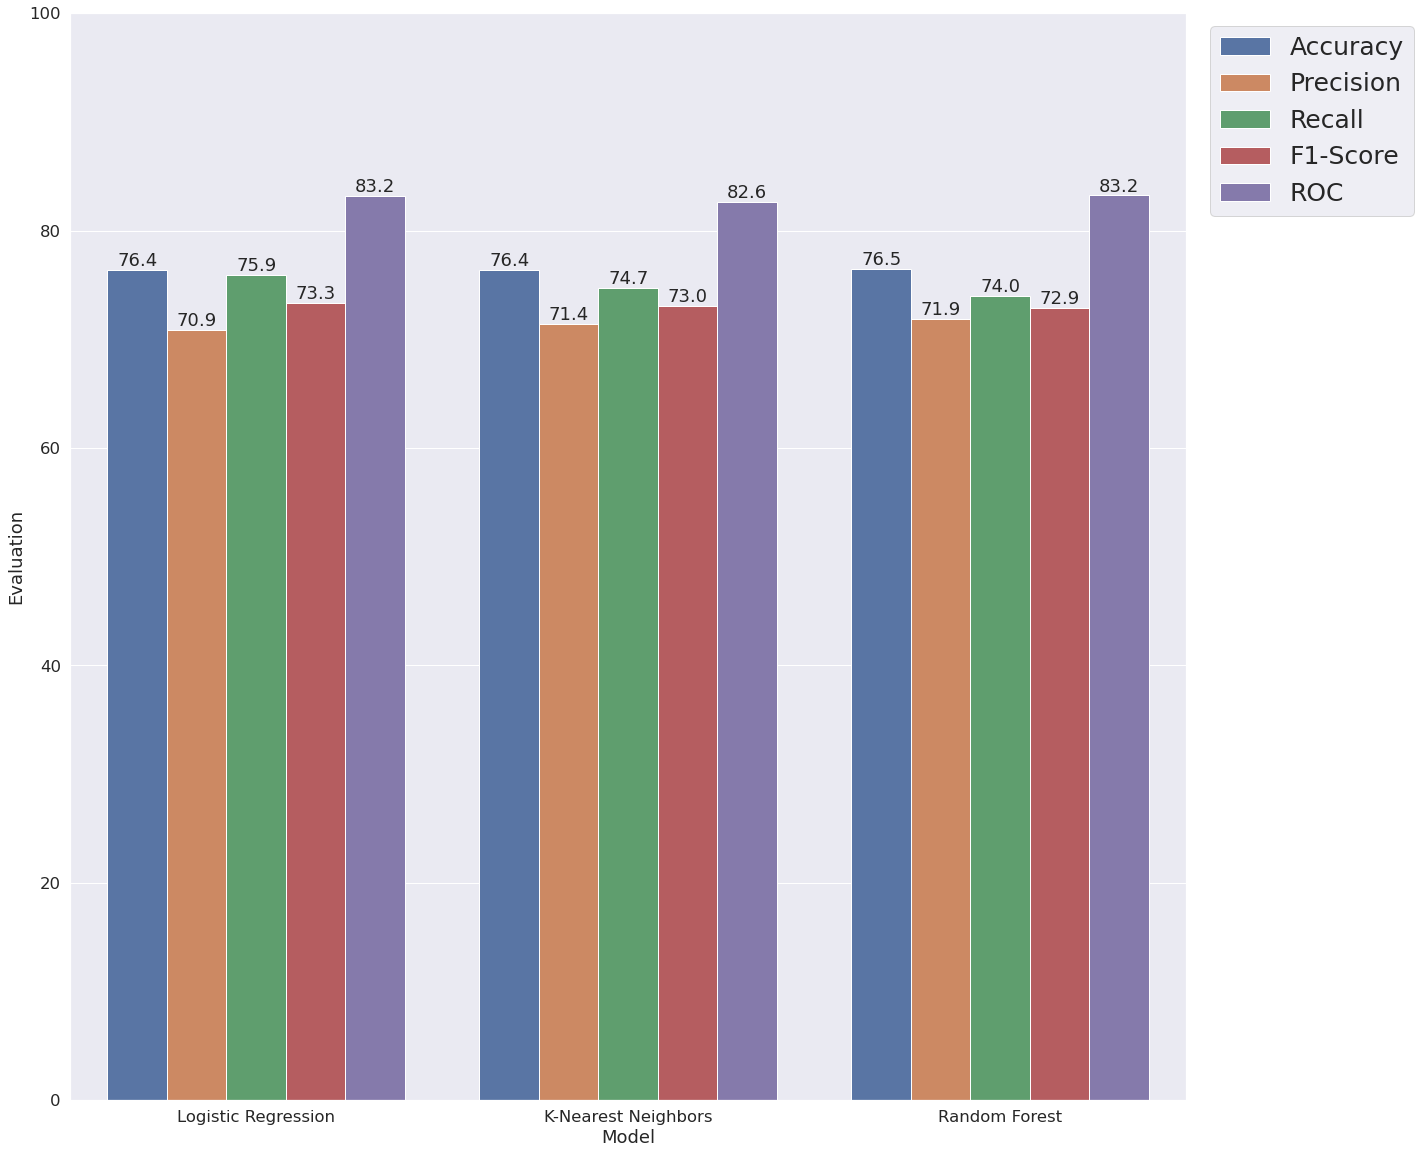

In [434]:
fig,ax = plt.subplots(figsize=(20,20))
splot = sns.barplot(x=final_results["Model"], y = final_results["Evaluation"],hue=final_results["Method"],data=final_results)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2,fontsize=25)
plt.ylim([0,100]);
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [435]:
# Reference -----> https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot
def plot_roc(models,X_test,y_test):
    result_rocs = pd.DataFrame(columns=['classifiers', 'fpr','tpr'])
    for name, model in models.items():
        yproba = model.predict_proba(X_test)[::,1]
        fpr, tpr, _ = roc_curve(y_test,  yproba)
        result_rocs = result_rocs.append({'classifiers':name,
                                        'fpr':fpr, 
                                        'tpr':tpr}, ignore_index=True)
    result_rocs.set_index("classifiers",inplace=True)
    fig = plt.figure(figsize=(8,6))
    for i in result_rocs.index:
        plt.plot(result_rocs.loc[i]['fpr'], 
             result_rocs.loc[i]['tpr'], 
             linewidth=3,
             label="{}".format(i))
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=20)
    plt.legend(prop={'size':13}, loc='lower right')
    plt.show()

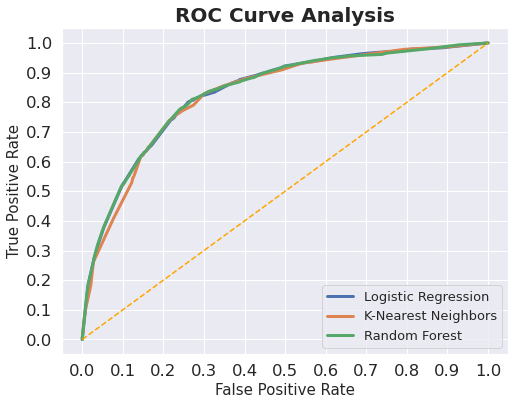

In [436]:
plot_roc(models,X_test,y_test)

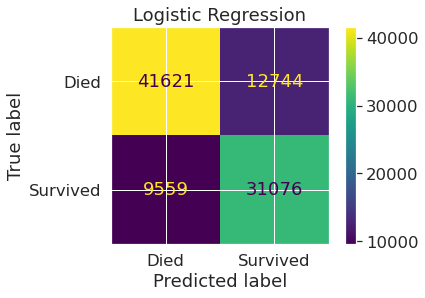

In [437]:
np.random.seed(42)
plot_confusion_matrix(models["Logistic Regression"], X_train, y_train, display_labels=["Died","Survived"]);
plt.title("Logistic Regression");

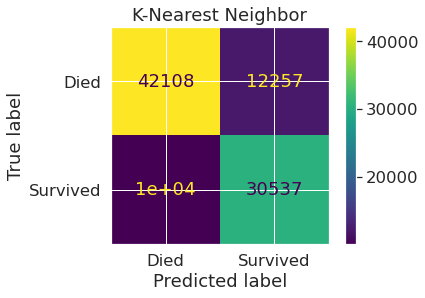

In [438]:
np.random.seed(42)
plot_confusion_matrix(models["K-Nearest Neighbors"], X_train, y_train,display_labels=["Died","Survived"]);
plt.title("K-Nearest Neighbor");

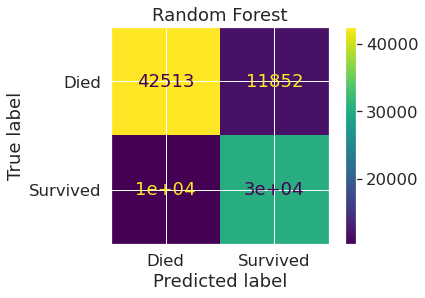

In [439]:
np.random.seed(42)
plot_confusion_matrix(models["Random Forest"], X_train, y_train,display_labels=["Died","Survived"]);
plt.title("Random Forest");